# A script to format the data from json format to a numpy matrix

In [1]:
import json, os, datetime
import numpy as np
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(file):

    with open(file) as f:
        data = json.load(f)
        meta_data = data['Meta Data']
        time_series = data['Time Series (Daily)']
        
    return meta_data, time_series

In [3]:
#Converts string "yyyy-mm-dd" to days since since 0001-01-01. 
def to_date_value(date):
    year, month, day = date.split("-")
    t = datetime.date(int(year),int(month),int(day))
    date_value = date2num(t)
    return date_value

In [4]:
#Converts json time series data to numpy matrix with rows being datapoints and columns selected values
def to_matrix(time_series, selected_columns):
    n_datapoints = len(time_series.keys())
    data_matrix = np.zeros([n_datapoints,len(selected_columns)+1])
    
    i = 0
    for date in time_series.keys():
    
        date_value = to_date_value(date)
        fields = time_series[date]
        
        values = [float(fields[column]) for column in selected_columns]
        
        data_matrix[i,:] = [date_value] + values
    
        i+= 1
    return data_matrix

In [5]:
# Should there be missing values in form of zeroes they are set as average of surrounding values. 
def interpolate_zeros(data_matrix):
    
    interpolated_matrix = data_matrix.copy()
    
    n_datapoints, n_columns = np.shape(data_matrix)
    
    for i in range(2,n_datapoints-2):
        for j in range(1,n_columns):
            
            if(interpolated_matrix[i,j] == 0):
                interpolated_matrix[i,j] = (data_matrix[i-2,j] + data_matrix[i+2,j])/2
    return interpolated_matrix

In [6]:
# Takes the moving average of all columns in data_matrix except for date column (0), MVA size is set by offset
def moving_average(data_matrix, offset):
    
    mva_matrix = data_matrix.copy()
    
    n_datapoints, n_columns = np.shape(data_matrix)
    
    for i in range(1,n_datapoints):
        for j in range(1,n_columns):
            
            if(i < offset):
                mva_matrix[i,j] = np.mean(data_matrix[0:i,j])
            else:
                mva_matrix[i,j] = np.mean(data_matrix[i-offset:i,j])
    return mva_matrix

In [7]:
# Normalizes time series so that the values are between 1 and zero
def normalize(data_matrix):
    normalized_matrix = data_matrix.copy()
    normalized_matrix[:,1:] /= np.max(normalized_matrix[:,1:],axis=0)
    return normalized_matrix

In [8]:
# Sets any occurances of missing data (zeros) as the previous value
def remove_zeros(data_matrix):
    
    n_datapoints,n_symbols = np.shape(data_matrix)
    
    for i in range(1,n_datapoints):
        for j in range(0,n_symbols):
            if(data_matrix[i,j] == 0):
                data_matrix[i,j] = data_matrix[i-1,j]
                
    return data_matrix

In [9]:
# Expresses data at point t as change from t-1
def to_changes(data_marix):
     
    n_datapoints, _ = np.shape(data_matrix)
    change_matrix = np.zeros(np.shape(data_marix))
    
    for i in range(n_datapoints-1):
        change_matrix[i+1,:] = (data_matrix[i+1,:]-data_matrix[i,:])/data_matrix[i,:]
        
        
    return change_matrix[1:,:]
        

## See how data is distrubuted through time

To get a sense of how many relevant entries we have we can examine the introduction dates of the stocks in the dataset

In [10]:
# Iterates over jsonfiles of stockdata retrieved from Alpha vantage API to extract earliest entry for visualization
start_dates = []
for file in os.listdir("raw_data/"):
    with open('raw_data/'+file) as f:
        data = json.load(f)
        meta_data = data['Meta Data']
        time_series = data['Time Series (Daily)']
        date_range = list(np.array(list(time_series.keys()))[[-1,0]])
        n_datapoints = len(time_series)
        start_dates += [int(date_range[0].split("-")[0])]


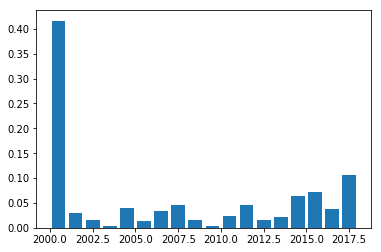

In [11]:
plt.hist(start_dates,rwidth=0.8,bins=18 ,cumulative=False, normed = True)
plt.show()      

More than 40 % of the stocks have "complete" 5-year history

## Load data to make sure dates line up

In [12]:
all_data = {}

for file in [file for file in os.listdir('raw_data/') if file.endswith('.json')]:
    meta_data, time_series = load_data('raw_data/' + file)
    symbol = file.split(".")[0]
    
    for date in time_series.keys():
        
        all_data.setdefault(date,{})
        all_data[date][symbol] = time_series[date]
    
print("complete")

complete


In [13]:
all_data['2017-02-02']['ABB']

{'1. open': '207.0000',
 '2. high': '207.2000',
 '3. low': '204.6000',
 '4. close': '206.6000',
 '5. adjusted close': '205.0108',
 '6. volume': '973486',
 '7. dividend amount': '0.0000',
 '8. split coefficient': '1.0000'}

In [14]:
file_name = 'processed_data/compiled_data_aligned_dates.json'
with open(file_name, 'w') as outfile:
            json.dump(all_data, outfile)

## Convert dictionary to numpy array, with -1 for missing value

In [15]:
with open("processed_data/large_cap_symbols.txt") as f:
    symbols = []
    sym_to_num = {}
    i = 0
    for line in f.readlines():
        
        symbol = line
        symbol = symbol.replace("\n","")
        symbol = symbol.replace(" ","-")
        
        symbols += [symbol]
        sym_to_num[symbol] = i
        i += 1

In [16]:
feat_to_num = {'1. open': 0,
  '2. high': 1,
  '3. low': 2,
  '4. close': 3,
  '5. adjusted close': 4,
  '6. volume': 5,
  '7. dividend amount': 6,
  '8. split coefficient': 7}

In [17]:
n_dates = len(all_data.keys())
n_symbols = len(symbols)
n_features = 8

In [18]:
data_matrix = -1*np.ones([n_dates,n_symbols, n_features])
print(np.shape(data_matrix))

i=0
for date in list(all_data.keys()):
    for symbol in list(all_data[date].keys()):
        for feature in list(all_data[date][symbol].keys()):
            data_matrix[i,sym_to_num[symbol], feat_to_num[feature]] = all_data[date][symbol][feature]
    i+=1


(4720, 377, 8)


In [19]:
data_matrix[:10,:5,0]

array([[ 142.44,  187.6 ,  193.2 ,   50.15,  208.5 ],
       [ 141.84,  187.35,  192.2 ,   50.05,  207.7 ],
       [ 141.04,  190.1 ,  194.  ,   50.95,  211.3 ],
       [ 142.54,  193.2 ,  199.  ,   51.65,  213.4 ],
       [ 142.1 ,  193.5 ,  203.6 ,   52.6 ,  210.5 ],
       [ 140.24,  193.85,  199.  ,   51.3 ,  212.4 ],
       [ 142.38,  193.65,  200.8 ,   51.5 ,  212.1 ],
       [ 143.94,  191.3 ,  203.8 ,   51.8 ,  207.8 ],
       [ 138.42,  192.9 ,  206.8 ,   51.65,  210.5 ],
       [ 137.1 ,  198.9 ,  201.8 ,   52.  ,  215.8 ]])

In [20]:
with open('dates.txt', 'w') as f:
    for date in list(all_data.keys()):   
        f.write(date+"\n")

In [21]:
np.save("all_data_with_aligned_dates.npy",data_matrix)
np.save("all_data_with_aligned_dates_DIC.npy",sym_to_num)

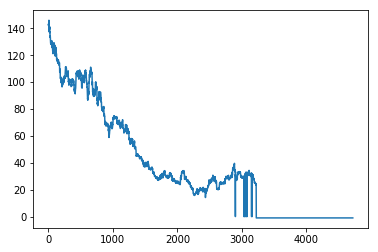

In [22]:
plt.plot(data_matrix[:,0,1])
plt.show()

## Interpolate zero-valeues

The data shows some strange zero-valued entries, probably a sign of incomplete data, nevertheless it has to be dealt with, here using simple interpolation

In [23]:
for i  in range(n_dates):
    for j in range(n_symbols):
        for k in range(5):
            if(data_matrix[i,j,k] == 0):
                x = data_matrix[i-1,j,k]
                l = 1
                while(data_matrix[i+l,j,k] == 0):
                    l += 1
                y = data_matrix[i+l,j,k]
                
                data_matrix[i,j,k] = (x+y)/2

In [24]:
np.save("processed_data/aligned_dates/all_data_with_aligned_dates.npy",data_matrix)
np.save("processed_data/aligned_dates/all_data_with_aligned_dates_DIC.npy",sym_to_num)

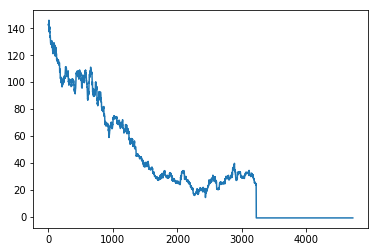

In [25]:
plt.plot(data_matrix[:,0,1])
plt.show()

## Convert to percentual changes

In [26]:
changes_matrix = data_matrix.copy()
for i  in range(n_dates-1):
    for j in range(n_symbols):
        for k in range(5):
            if(changes_matrix[i+1,j,k] != -1):
                changes_matrix[i,j,k] = (changes_matrix[i,j,k] - changes_matrix[i+1,j,k])/changes_matrix[i+1,j,k]
                
            else:
                changes_matrix[i,j,k] = 0
                changes_matrix[i+1,j,k] = 0

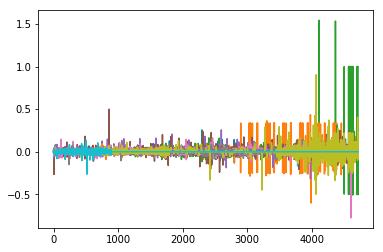

In [27]:
plt.plot(changes_matrix[:-2,:20,4])
plt.show()

In [28]:
np.save("processed_data/aligned_dates/all_data_with_aligned_dates_changes.npy",changes_matrix[:-2,:,:])
np.save("processed_data/aligned_dates/all_data_with_aligned_dates_changes_DIC.npy",sym_to_num)

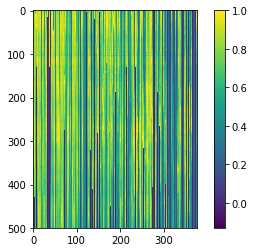

In [29]:
tmp = data_matrix[:,:,0]/np.max(data_matrix[:,:,0],axis=0)
plt.imshow(tmp[:500,:])
plt.colorbar()

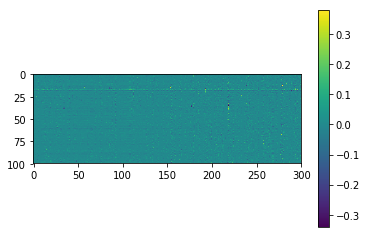

In [30]:
plt.imshow(changes_matrix[400:500,:300,0])
plt.colorbar()
plt.show()

# Idea: truncate changes matrix so that all changes above 10 % becomes 10 %, maybe easier for network?